# 1. 이미지로드 & 전처리

In [17]:
# ===== A4부분만 감지해서 크롭하기 =====
# 구현 필요
#방법1: 그냥 사진 가지고 와서 A4부분 classification & localization해서 그 부분만 크롭해서 상하좌우 수평 맞추기
#방법2: 애초에 사진 찍을때부터 네모박스 가이드라인을 주고 on-device로 가이드라인과 카메라화면의 A4용지가 일치할때 자동으로 캡쳐한 사진을 넘기기

In [18]:
# ===== 대비 최대로 높이기 =====
# 지금은 로컬에서 수동으로함 (코드 구현 필요)

In [19]:
# ===== gray로 바꾸고 adaptive threshodling으로 image segmentation =====
# 지금은 로컬에서 c++코드로함. 
# 구글 코랩 python 코드로 하는 것은 기술검증일 뿐, 실제 구현은 서버에서 c++코드로 할 예정

In [20]:
# package import
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

# midpoint찾는 함수
def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)
 
'''
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to the input image")
ap.add_argument("-w", "--width", type=float, required=True,
	help="width of the left-most object in the image (in inches)")
args = vars(ap.parse_args())'''

'\n# construct the argument parse and parse the arguments\nap = argparse.ArgumentParser()\nap.add_argument("-i", "--image", required=True,\n\thelp="path to the input image")\nap.add_argument("-w", "--width", type=float, required=True,\n\thelp="width of the left-most object in the image (in inches)")\nargs = vars(ap.parse_args())'

In [21]:
!pip install imutils
!pip install --upgrade imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


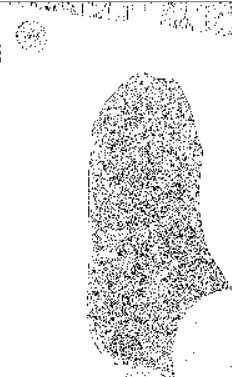

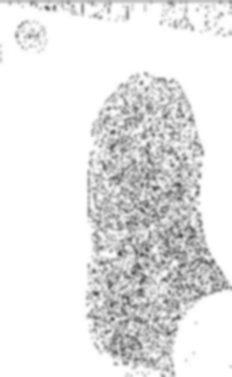

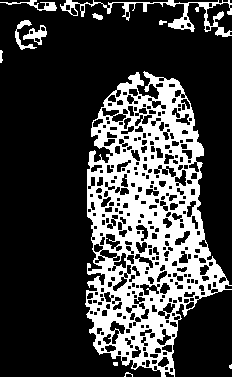

11


In [22]:
from google.colab.patches import cv2_imshow

#img_path = "adaptive_threshold3.jpg"
#image = cv2.imread(args["image"])
#image = cv2.imread(img_path) 

#1. url로 이미지 불러오기
import numpy as np 
import urllib.request 

def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype='uint8')
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)

  return image

url = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbY7ypX%2FbtrTgmi3vap%2FlcgUXJHjO1Xm7upUp4fwd0%2Fimg.jpg" #블로그에 위의 전처리 끝난 이미지 업로드함
image = url_to_image(url)
cv2_imshow(image)

# 2. gray로 변경 & blur 처리
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)
cv2_imshow(gray)

# 3-1. edge detection 
# 3-2. dilation + erosion to close gaps in between object edges
# 원래 threshold (50,100)이었음
edged = cv2.Canny(gray, 70, 120) 
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)
cv2_imshow(edged)

# 4-2. find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None

#bounding box 개수 출력
print(len(cnts))

# 2. bounding box 마다 검사

In [23]:
# contour마다 loop돌기
#유효한 cnt개수
cnt_len = 0

for c in cnts:
  # contour가 충분히 크지 않으면 무시
  if cv2.contourArea(c) < 100 :
    continue
  else :
    cnt_len = cnt_len + 1

	# compute the rotated bounding box of the contour
  orig = image.copy()
  box = cv2.minAreaRect(c)
  box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
  box = np.array(box, dtype="int")
 
	# order the points in the contour such that they appear
	# in top-left, top-right, bottom-right, and bottom-left
	# order, then draw the outline of the rotated bounding
	# box
  box = perspective.order_points(box)
  cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
 
	# loop over the original points and draw them
  for (x, y) in box:
    cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
  
print(cnt_len)

5


정렬된 bounding box들 중에서 midpoint들을 찾아내기

In [24]:
for c in cnts:
  # unpack the ordered bounding box, then compute the midpoint
  # between the top-left and top-right coordinates, followed by
  # the midpoint between bottom-left and bottom-right coordinates
  (tl, tr, br, bl) = box
  (tltrX, tltrY) = midpoint(tl, tr)
  (blbrX, blbrY) = midpoint(bl, br)

  # compute the midpoint between the top-left and top-right points,
  # followed by the midpoint between the top-righ and bottom-right
  (tlblX, tlblY) = midpoint(tl, bl)
  (trbrX, trbrY) = midpoint(tr, br)

  # draw the midpoints on the image
  cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
  cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
  cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
  cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)

  # draw lines between the midpoints
  cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),(255, 0, 255), 2)
  cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),(255, 0, 255), 2)

# 3. Object Size 측정하기

reference object를 기준으로 pixelsPerMetric변수 초기화

In [25]:
for c in cnts:
  # compute the Euclidean distance between the midpoints
  dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
  dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

  # if the pixels per metric has not been initialized, then
  # compute it as the ratio of pixels to supplied metric
  # (in this case, inches)
  if pixelsPerMetric is None:
    #pixelsPerMetric = dB / args["width"] 
    pixelsPerMetric = dB / 2 #args["width"] = 기준물체의 가로, 우리는 동전 2cm라 가정

  # compute the size of the object
  dimA = dA / pixelsPerMetric
  dimB = dB / pixelsPerMetric

  # draw the object sizes on the image
  cv2.putText(orig, "{:.1f}in".format(dimA), (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 0), 2)
  cv2.putText(orig, "{:.1f}in".format(dimB), (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 0), 2)

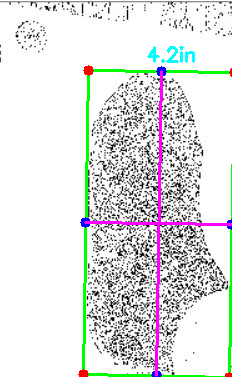

In [26]:
# show the output image
#cv2.imshow("Image", orig)
cv2_imshow(orig)
#cv2.waitKey(0)